In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.stats import zscore


In [4]:
# Ruta de la carpeta deep_mq
deep_folder = 'data\\lunar\\training\\data\\S12_GradeA\\deep_mq'

In [13]:
def detect_anomalies_in_deep_mq(folder_path, contamination_threshold=0.1, speed_threshold=2.0):
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            data_df = pd.read_csv(file_path)  # Cargar el archivo CSV
            
            # Verificar columnas
            print(f"\nColumnas en {filename}:")
            print(data_df.columns)

            # Asegúrate de que las columnas necesarias estén presentes
            if 'velocity(m/s)' in data_df.columns and 'time_abs(%Y-%m-%dT%H:%M:%S.%f)' in data_df.columns:
                # Convertir la columna de tiempo a datetime
                data_df['time_abs(%Y-%m-%dT%H:%M:%S.%f)'] = pd.to_datetime(data_df['time_abs(%Y-%m-%dT%H:%M:%S.%f)'])

                # Aplicar Isolation Forest
                model = IsolationForest(contamination=contamination_threshold)
                data_df['anomaly'] = model.fit_predict(data_df[['velocity(m/s)']])

                # Convertir -1 (anomalías) y 1 (normal) a booleano
                data_df['anomaly'] = data_df['anomaly'] == -1

                # Agregar un criterio de velocidad
                data_df['anomaly'] = data_df['anomaly'] | (data_df['velocity(m/s)'] > speed_threshold)

                # Graficar resultados
                plt.figure(figsize=(12, 6))
                plt.plot(data_df['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], data_df['velocity(m/s)'], label='Datos', color='blue', alpha=0.5)
                plt.scatter(data_df[data_df['anomaly']]['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], 
                            data_df[data_df['anomaly']]['velocity(m/s)'], 
                            color='red', label='Anomalías')
                
                plt.title(f'Detección de Anomalías en {filename}')
                plt.xlabel('Tiempo Absoluto')
                plt.ylabel('Velocidad (m/s)')
                plt.legend()
                plt.grid()
                plt.show()
            else:
                print(f"Las columnas necesarias no están presentes en {filename}.")





Columnas en xa.s12.00.mhz.1970-04-26HR00_evid00007.csv:
Index(['time_abs(%Y-%m-%dT%H:%M:%S.%f)', 'time_rel(sec)', 'velocity(m/s)'], dtype='object')


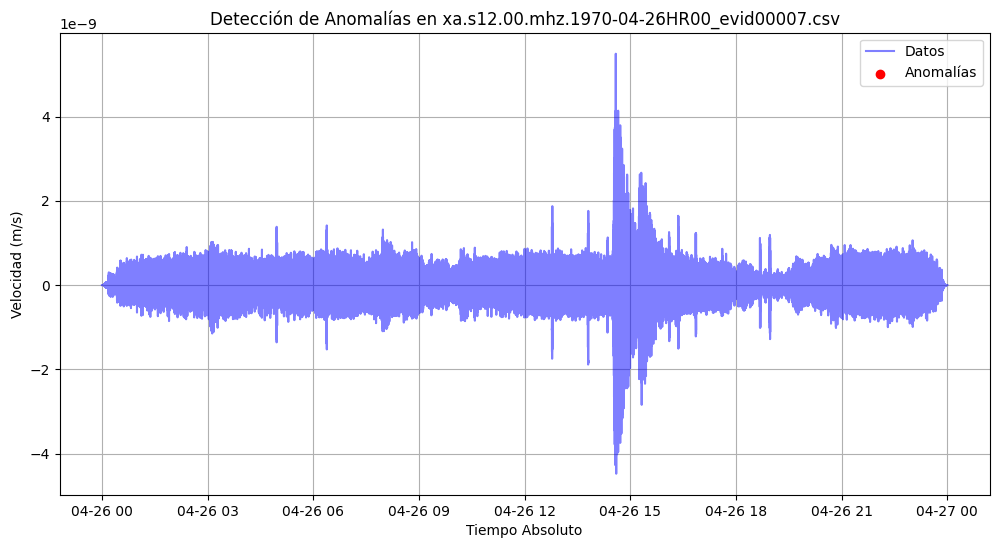


Columnas en xa.s12.00.mhz.1970-07-20HR00_evid00011.csv:
Index(['time_abs(%Y-%m-%dT%H:%M:%S.%f)', 'time_rel(sec)', 'velocity(m/s)'], dtype='object')


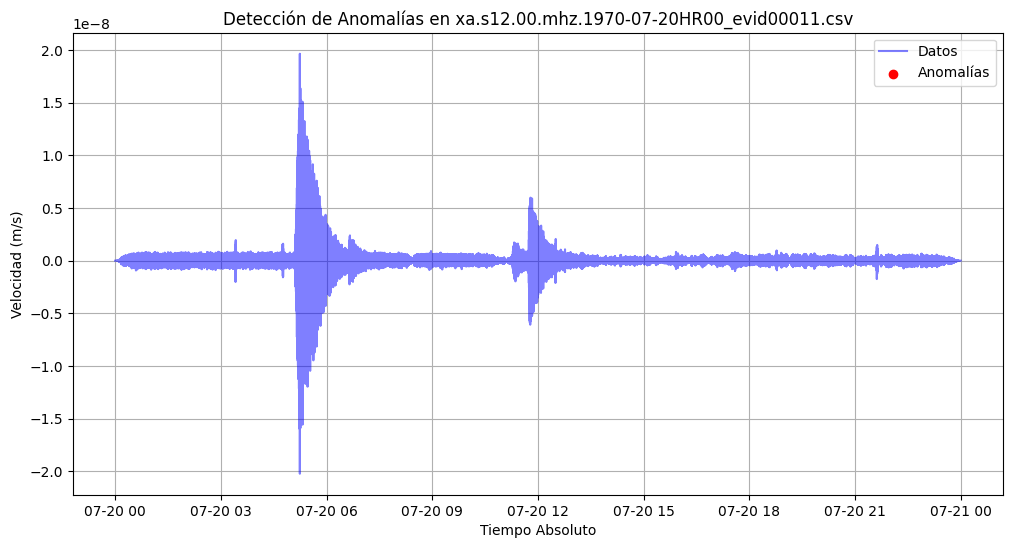


Columnas en xa.s12.00.mhz.1970-12-27HR00_evid00019.csv:
Index(['time_abs(%Y-%m-%dT%H:%M:%S.%f)', 'time_rel(sec)', 'velocity(m/s)'], dtype='object')


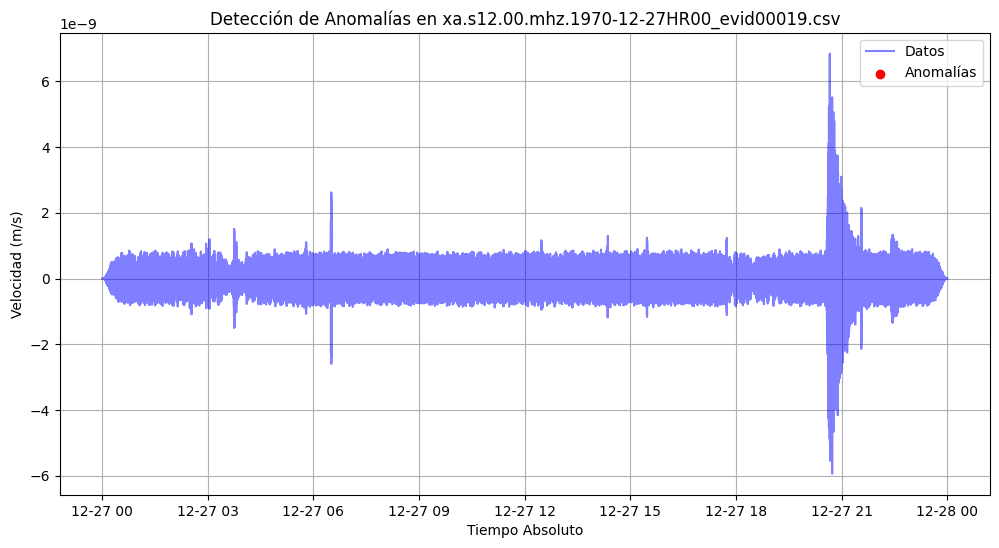


Columnas en xa.s12.00.mhz.1970-12-31HR00_evid00021.csv:
Index(['time_abs(%Y-%m-%dT%H:%M:%S.%f)', 'time_rel(sec)', 'velocity(m/s)'], dtype='object')


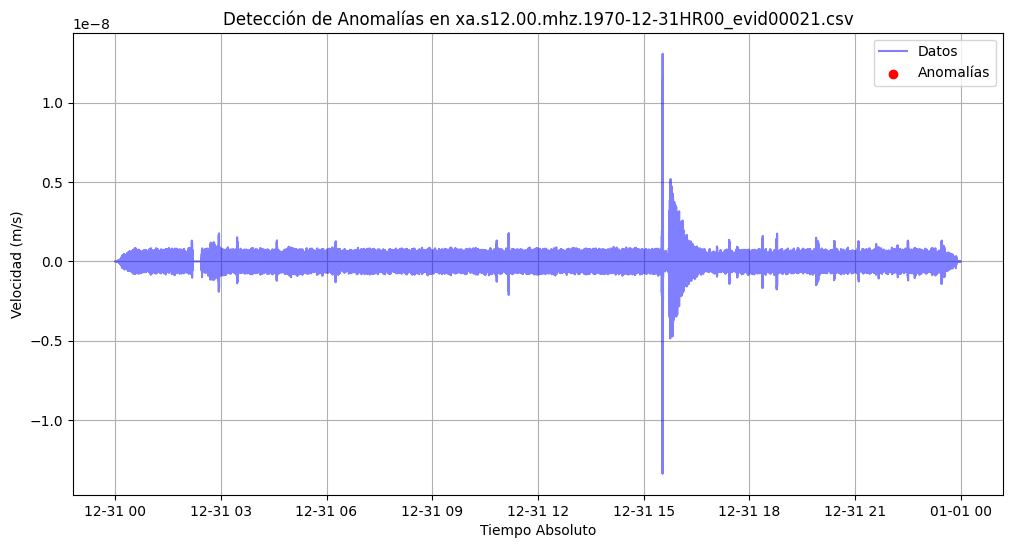


Columnas en xa.s12.00.mhz.1971-01-28HR00_evid00023.csv:
Index(['time_abs(%Y-%m-%dT%H:%M:%S.%f)', 'time_rel(sec)', 'velocity(m/s)'], dtype='object')


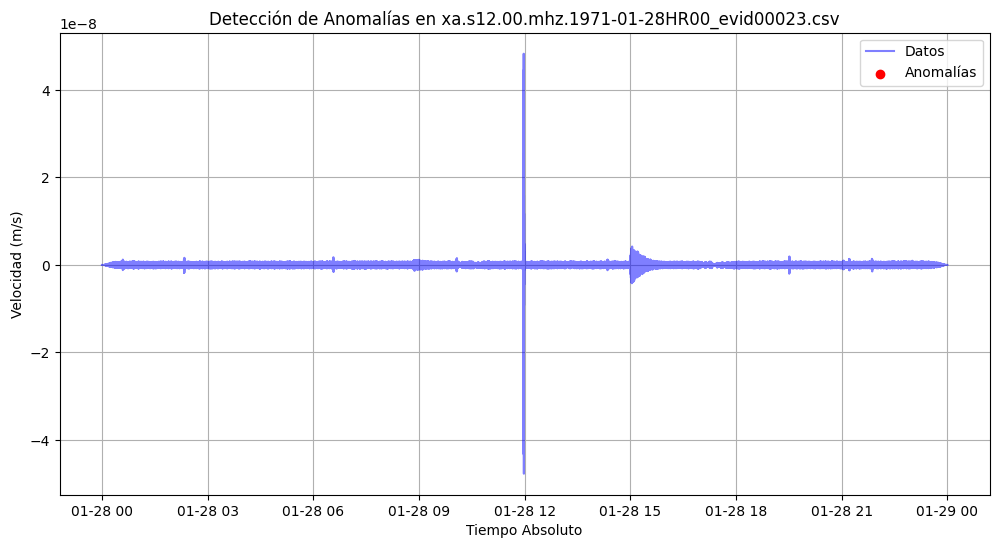


Columnas en xa.s12.00.mhz.1973-03-01HR00_evid00093.csv:
Index(['time_abs(%Y-%m-%dT%H:%M:%S.%f)', 'time_rel(sec)', 'velocity(m/s)'], dtype='object')


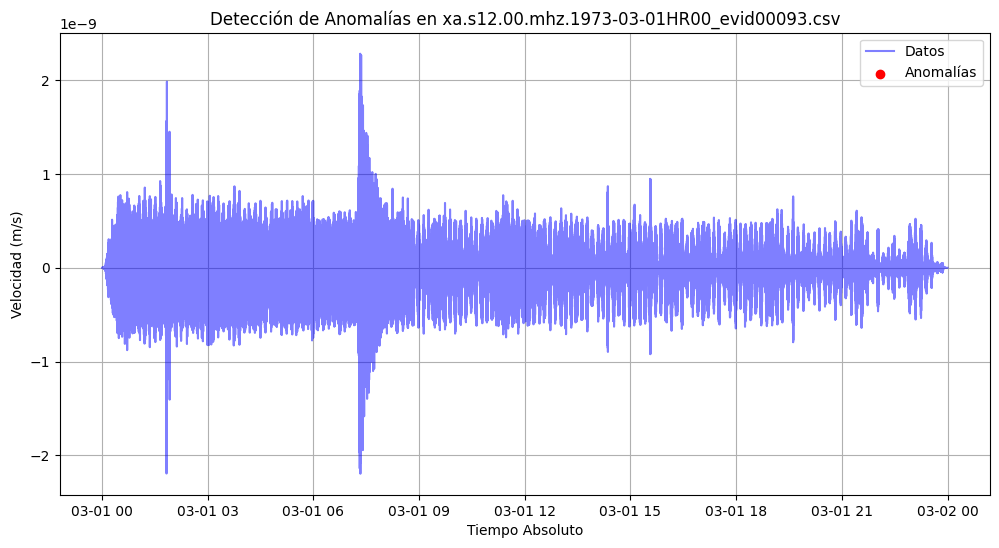


Columnas en xa.s12.00.mhz.1973-06-05HR00_evid00108.csv:
Index(['time_abs(%Y-%m-%dT%H:%M:%S.%f)', 'time_rel(sec)', 'velocity(m/s)'], dtype='object')


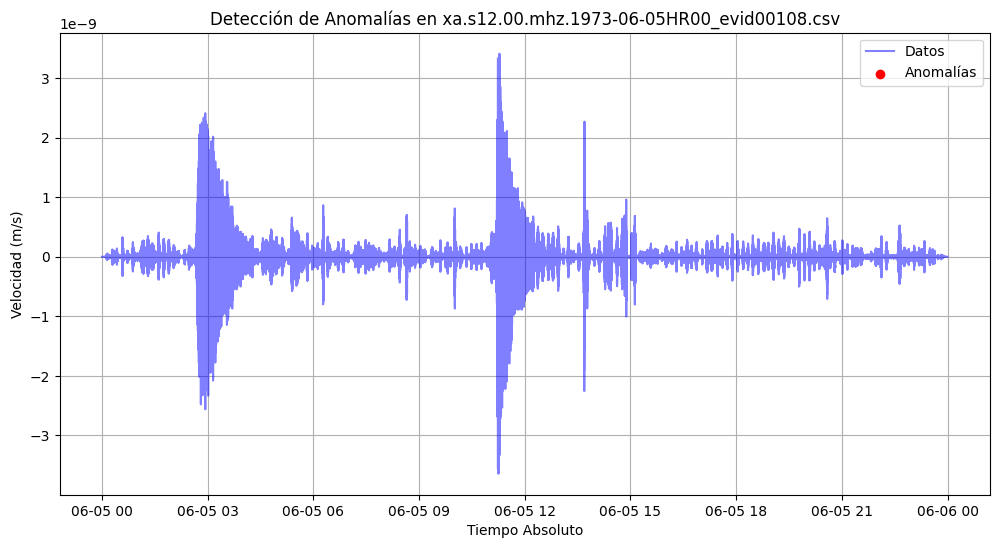


Columnas en xa.s12.00.mhz.1973-07-20HR00_evid00117.csv:
Index(['time_abs(%Y-%m-%dT%H:%M:%S.%f)', 'time_rel(sec)', 'velocity(m/s)'], dtype='object')


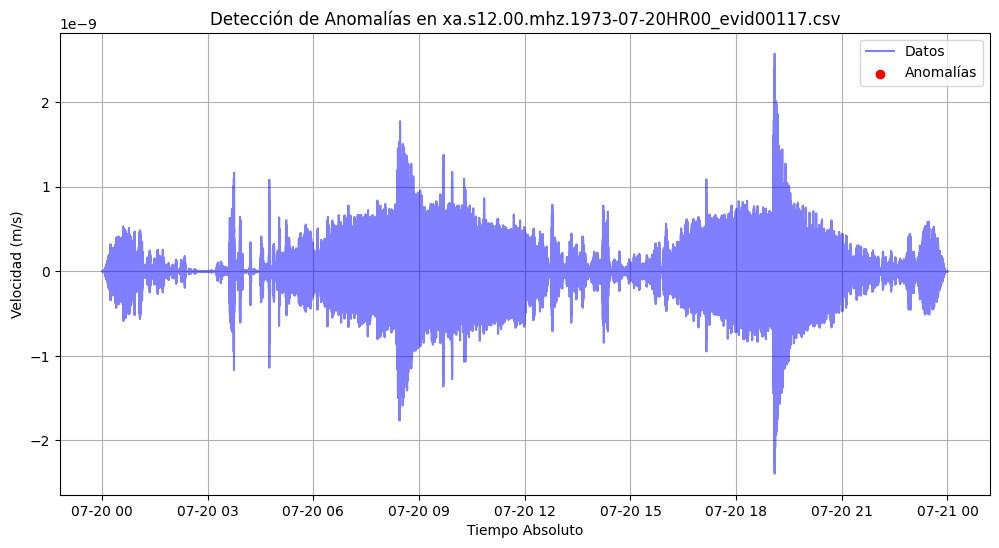


Columnas en xa.s12.00.mhz.1974-04-26HR00_evid00144.csv:
Index(['time_abs(%Y-%m-%dT%H:%M:%S.%f)', 'time_rel(sec)', 'velocity(m/s)'], dtype='object')


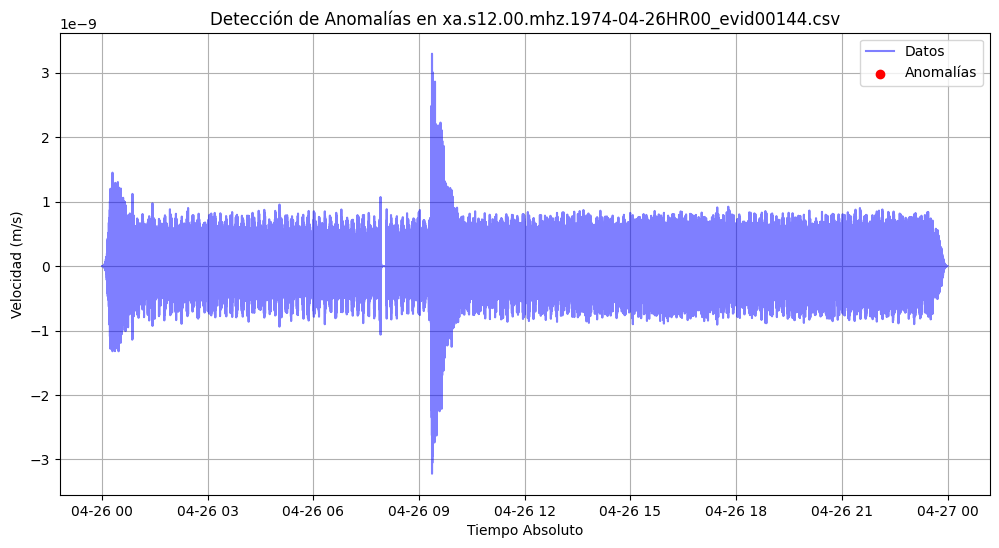

In [14]:

# Ejecutar la función para detectar anomalías con nuevos parámetros
detect_anomalies_in_deep_mq(deep_folder, contamination_threshold=0.15, speed_threshold=2.0)